[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/CMU-IDeeL/CMU-IDeeL.github.io/blob/master/F25/document/Recitation_0_Series/0.11/0_11_Datasets_Part_1.ipynb)

# Recitation 0.11: Datasets

# Imports

In [ ]:
import  os
import  glob
import  numpy as np
import  pandas as pd
from    tqdm.notebook import tqdm
import  torch
from    torch.utils.data import Dataset

In [ ]:
# We will be connecting to Kaggle through an API .. This is the easiest way to get data.
# !mkdir ~/.kaggle

# with open("/root/.kaggle/kaggle.json", "w+") as f:
#     f.write('{"username": "", "key": ""}')

# !chmod 600 ~/.kaggle/kaggle.json

# Introduction to Datasets

In this recitation, you will learn about different datasets that will be used in our class for part 2s of the homeworks.

## Numpy Dataset

> Create a Numpy array and save it as .npy file.
>
> (In Google Colab, default working directory is /content/, and the following code will save the array to /content/tmp_array.npy

In [ ]:
tmp_array = np.ones((3,3))
np.save("tmp_array.npy", tmp_array)

> Loading Numpy array from .npy file

In [ ]:
x = np.load("tmp_array.npy")
x # To print the loaded array

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])



```
# This is formatted as code
```

## Pandas Dataset

<b>Note: </b> Pandas library is not usually used for datasets in our homeworks. However, you will need pandas for writing your inference results into CSV files, which will be used for Kaggle submission.

> Generating a dummy submission table (pandas DataFrame object)

In [ ]:
output = pd.DataFrame()
# Set the column names as 'id' and 'label'
output['id'] = np.array(range(5))
output['label'] = np.array(range(10,20,2))
output

,id,label
0,0,10
1,1,12
2,2,14
3,3,16
4,4,18


> Save the table to CSV file

In [ ]:
output.to_csv("submission.csv", index = False)

> Load CSV file

In [ ]:
output_read = pd.read_csv("submission.csv")
output.head() # Printing the loaded table, .head() method extracts the first N(usually five) rows of the table.

,id,label
0,0,10
1,1,12
2,2,14
3,3,16
4,4,18


## Tensor Data Types
PyTorch adopts the
default 64-bit integer data type from Python. We can access the data type of a tensor via the .dtype
attribute of a tensor:


In [ ]:
tensor1d = torch.tensor([1, 2, 3])
print(tensor1d.dtype)

torch.int64


If we create tensors from Python floats, PyTorch creates tensors with a 32-bit precision by default,
as we can see below:

In [ ]:
floatvec = torch.tensor([1.0, 2.0, 3.0])
print(floatvec.dtype)

torch.float32


This choice is primarily due to the balance between precision and computational efficiency. A 32-bit
floating point number offers sufficient precision for most deep learning tasks, while consuming less
memory and computational resources than a 64-bit floating point number. Moreover, GPU
architectures are optimized for 32-bit computations, and using this data type can significantly speed
up model training and inference.



> Common PyTorch Tensor operations

Comprehensive coverage of all the different PyTorch tensor operations and commands is outside
the scope of this book. However, we will briefly describe relevant operations as we introduce them
throughout the book.


In [ ]:
tensor2d = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(tensor2d)

tensor([[1, 2, 3],
        [4, 5, 6]])


In addition, the .shape attribute allows us to access the shape of a tensor:

In [ ]:
print(tensor2d.shape)

torch.Size([2, 3])


As you can see above, .shape returns [2, 3], which means that the tensor has 2 rows and 3 columns.
To reshape the tensor into a 3 by 2 tensor, we can use the .reshape method:

In [ ]:
print(tensor2d.reshape(3, 2))

tensor([[1, 2],
        [3, 4],
        [5, 6]])


However, note that the more common command for reshaping tensors in PyTorch is .view():

In [ ]:
print(tensor2d.view(3, 2))

tensor([[1, 2],
        [3, 4],
        [5, 6]])


Similar to .reshape and .view, there are several cases where PyTorch offers multiple syntax options
for executing the same computation. This is because PyTorch initially followed the original Lua
Torch syntax convention but then also added syntax to make it more similar to NumPy upon
popular request.
Next, we can use .T to transpose a tensor, which means flipping it across its diagonal. Note that
this is similar from reshaping a tensor as you can see based on the result below:

In [ ]:
print(tensor2d.T)

tensor([[1, 4],
        [2, 5],
        [3, 6]])


Lastly, the common way to multiply two matrices in PyTorch is the .matmul method:

In [ ]:
print(tensor2d.matmul(tensor2d.T))

tensor([[14, 32],
        [32, 77]])


However, we can also adopt the @ operator, which accomplishes the same thing more compactly:

In [ ]:
print(tensor2d @ tensor2d.T)

tensor([[14, 32],
        [32, 77]])


For readers who'd like to browse through all the different tensor operations available in PyTorch
(hint: we won't need most of these), I recommend checking out the official documentation at
https://pytorch.org/docs/stable/tensors.html.

## Pytorch Dataset (Class)

```torch.utils.data.Dataset``` is a PyTorch interface for reading, organizing, preprocessing your input data of different formats.

While PyTorch offers some datasets that work out of the box, you will need to implement your own PyTorch Dataset classes to adapt the dataset we provided, usually numpy files.

In this tutorial, we will teach you how to create your custom Dataset class.

For more information, check out PyTorch's documentation on [Datasets and Dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).



> Data loading pipeline for **PyTorch**

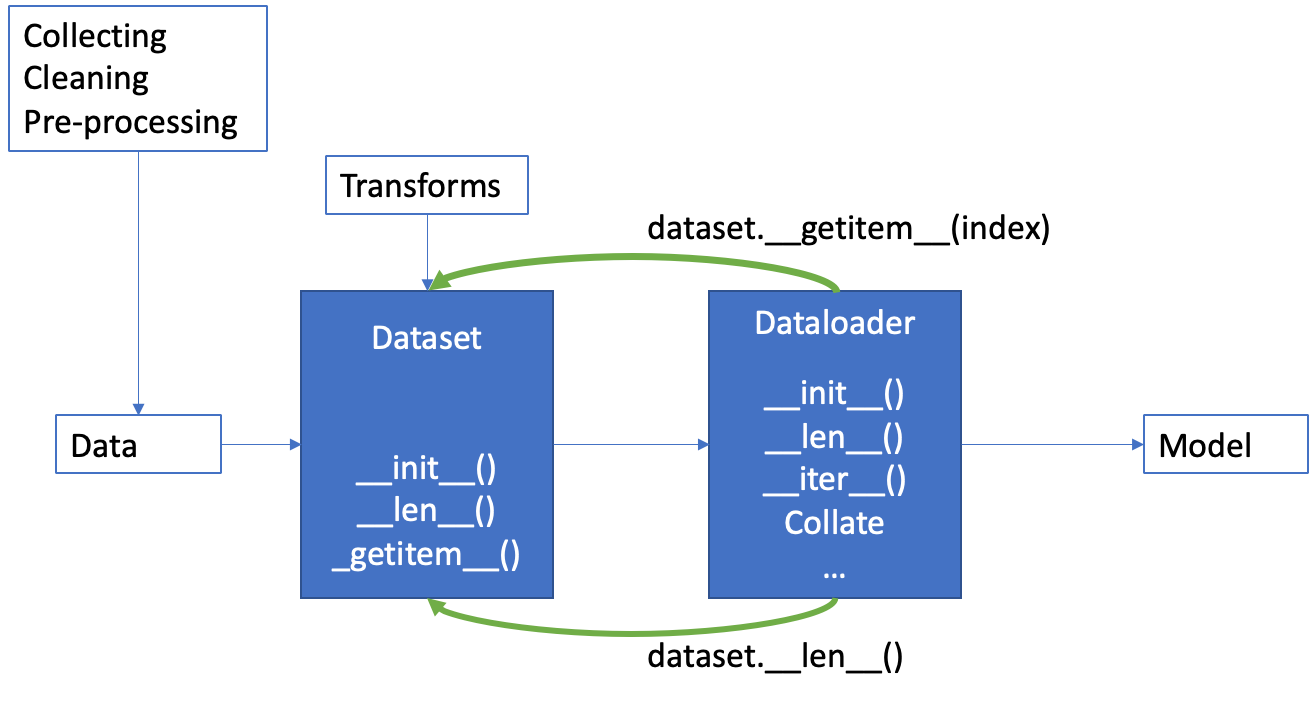

# BUILDING CUSTOM DATASETS IN PYTORCH

## General Approach

While it's tempting to jump right into defining a dataset, it is important to **understand your data first.** Whether you are working with audio data, image data, or data of another kind, load an example. Visualize it. See what shape the data is. Think about the process that generated this data in the first place. To the extent you can, think about whether the data is adequately representative of the problem you are trying to solve. These types of considerations are easy to skip on a homework, but they matter in the real world. Don't let PyTorch's lovely interface (which makes your life easier) allow you to forget all the complexity of the world and what we are trying to model!

## Basic PyTorch Dataset Definition

Now onto the nuts and bolts...

When defining a Dataset class, **you need to define 3 functions**:
* `__init__`: Constructor function.
* `__len__`: Returns the length of the dataset. Usually, you can store the length in the constructor and simply return it here.
* `__getitem__`: Retrieves an individual observation.

Additionally, you can also optionally define a custom `collate_fn` that will be passed to a Dataloader and controls how individual examples are batched.

## Additional Design Considerations

There are a few **design considerations**, your choices on which will depend on the situation. (No need to master these all at once, but food for thought). For instance:
* **Does your data fit into memory all at once? If so, you will probably want to load and preprocess all of your data in the `__init__` function rather than the `__getitem__` function**, because `__getitem__` is called every time your model requests data, meaning you want to reduce the computation time in this funcitno as much as possible. However, **if your data does not fit into memory all at once, you may have to create a "memory-efficient" dataset class that loads data in the `__getitem__` function.**

* **Do you want to instantiate your dataset object using xs and ys? What about passing it a path to a root directory?** Many of the datasets we will be working with from kaggle have a directory structure and directory names that will allow you to simply point to a directory and have your constructor function do the work!
  * Among other helpful functions, check out the `os.listdir` function [here](https://docs.python.org/3/library/os.html).
  * Also check out the `glob` package [here](https://docs.python.org/3/library/glob.html), which provides helpful pattern-matching functionality for filenames.

* **Should you have separate dataset classes for train (and validation) datasets versus test? (Hint: yes).** Why? Well, consider this: for your test data, do you have access to the ground truth information? No! So think about how your `__getitem__` function might be different.

* When building an initial working prototype (and if you are loading all examples into memory), do you need to load all your training examples? Maybe not. **Consider allowing yourself to limit the number of examples loaded in for quicker iteration until you know your training pipeline works and can begin to train.**

## Example: A Basic Dataset Class

A vanilla Dataset class is defined below. Think about how you might add some sprinkles!

In [ ]:
class MyDataset(Dataset):

  def __init__(self, xs, ys):

    self.xs = xs
    self.ys = ys
    self.length = len(self.xs)

  def __len__(self):
    return self.length

  def __getitem__(self, idx):

    return self.xs[idx], self.ys[idx]


class MyDatasetTest(Dataset):
  def __init__(self, xs):
    self.xs = xs
    self.length = len(self.xs)

  def __len__(self):
    return self.length

  def __getitem__(self,idx):
    return self.xs[idx]


> Constructing and indexing into a MyDataset instance

In [ ]:
######################################
#                                    #
#  Constructing a MyDataset object   #
#                                    #
######################################

# Here we are generating our dummy samples and labels
xs = list(range(10))
ys = list(range(10,20))

# Create an instance of MyDataset Class
dataset = MyDataset(xs, ys)

# Check the length of the dataset
print(f"len(dataset): {len(dataset)}")

######################################
#                                    #
#  Reading data from dataset object  #
#                                    #
######################################

# The indexing operation will call __getitem__ function.
# In this case, the 0th items in xs and ys are returned as a tuple.
x, y = dataset[0]
print(x, y)

# You can also pass the dataset to a loop
for x, y in dataset:
    print(x, y)
    break

# You can also use the __next__ method
x, y = next(iter(dataset))
print(x, y)

len(dataset): 10
0 10
0 10
0 10


## Exercise: Define your own PyTorch Dataset class

Fill in the blanks to define a Dataset that takes in a list of numpy sample and label files.

In [ ]:
class MyDataset(Dataset):
    # Constructor
    # x_files_paths will take in a list of numpy files, each file contains one sample
    # y_files_paths will take in a list of numpy files, each file contains one label
    def __init__(self, x_files_paths=[], y_files_paths=[]):
        self.x_files = x_files_paths
        self.y_files = y_files_paths

        # Assume that there will be same number of x and y files, and the filename would be either "x_{file_id}.npy" or "y_{file_id}.npy"
        # The file_id is a unique identifier for each training sample.
        # How can you make sure that the x and y loaded are in the same order?
        # HINT: SORT!

        self.x_files = _______
        self.y_files = _______

        # Fill in the below two lines(might require more) to load the numpy data and store it into class variables
        self.x = _________
        self.y = _________

        # Do some preprocessing to the data you loaded, be creative.
        _______

    # __len__ method returns how many samples(data) your Dataset contains
    def __len__(self):
        return ___________  # Fill

    # __getitem__ returns the item at index i
    def __getitem__(self, i):
        return ___________ # Fill

## Example: A Dataset based on Kaggle data

For most (if not all) of the homeworks, once you download data from Kaggle, you will have it in a directory similar to the following:

```
competition-name
  ├── dev-clean
      ├── features
      └── labels
  ├── test-clean
      └── features
  └── train-clean
      ├── features
      └── labels
```

Given this structure, you can write a Dataset class along the lines of the one below that constructs the dataset object using directory paths.

(Since we don't actually have data, this code won't do much, but it is given as a general sketch of how you might write the class.)

In [ ]:
class DirDataset(Dataset):

    def __init__(self, root, limit=None, transforms=None, debug=False):

        # (Optional) Store any arguments used outside constructor --------------
        # ...

        # Get filepaths --------------------------------------------------------
        feat_dir = os.path.join(root, 'features')
        label_dir = os.path.join(root, 'labels')

        if limit is None:
            feat_fnames = sorted(os.listdir(feat_dir))
            label_fnames = sorted(os.listdir(label_dir))
        else:
            feat_fnames = sorted(os.listdir(feat_dir))[:limit]
            label_fnames = sorted(os.listdir(label_dir))[:limit]

        feat_paths = [os.path.join(feat_dir, fname) for fname in feat_fnames]
        label_paths = [os.path.join(label_dir, fname) for fname in label_fnames]

        # Set length -----------------------------------------------------------
        assert len(feat_paths) == len(label_paths)
        self.length = len(feat_paths)

        # Loop through filepaths, load, preprocess, and store ------------------
        self.feats, self.labels = [], []
        for feat_path, label_path in tqdm(zip(feat_paths, label_paths)):

            # Load files
            feat = np.load(feat_path)
            label = np.load(label_path)

            # (Optional) Preprocessing
            # ...

            # Append to list
            self.feats.append(feat)
            self.labels.append(label)

        # (Optional) Concatenate and add context

        if debug: print('Dataset created')


    def __len__(self):

        return self.length

    def __getitem__(self, idx):

        return self.feats[idx], self.labels[idx]


class DirDatasetTest(Dataset):

    def __init__(self, root, limit=None, transforms=None, debug=False):
        """
        Note: This is identical to the above, just without labels.
        """

        # (Optional) Store any arguments used outside constructor --------------
        # ...

        # Get filepaths --------------------------------------------------------
        feat_dir = os.path.join(root, 'features')

        if limit is None:
            feat_fnames = sorted(os.listdir(feat_dir))
        else:
            feat_fnames = sorted(os.listdir(feat_dir))[:limit]

        feat_paths = [os.path.join(feat_dir, fname) for fname in feat_fnames]

        # Set length -----------------------------------------------------------
        self.length = len(feat_paths)

        # Loop through filepaths, load, preprocess, and store ------------------
        self.feats = []
        for feat_path in tqdm(feat_paths):

            # Load files
            feat = np.load(feat_path)

            # (Optional) Preprocessing
            # ...

            # Append to list
            self.feats.append(feat)

        # (Optional) Concatenate and add context

        if debug: print('Dataset created')


    def __len__(self):

        return self.length

    def __getitem__(self, idx):

        return self.feats[idx]


In [ ]:
train_dataset = DirDataset(os.path.join('competition-name', 'train-clean'))
valid_dataset = DirDataset(os.path.join('competition-name', 'dev-clean'))
test_dataset  = DirDatasetTest(os.path.join('competition-name', 'test-clean'))

Food for thought: Outside of the world of Kaggle, which very nicely splits train, dev, and test sets for you, how might you make these splits yourself?